In [190]:
# import os
# import shutil

# # Đường dẫn đến thư mục gốc và thư mục đích
# root_folder = 'WEDA-FALL/dataset/50Hz'
# destination_folder = 'WEDA-FALL_new/50Hz'

# os.makedirs(destination_folder, exist_ok=True)

# # Duyệt qua các thư mục D01 đến D11 và F01 đến F08
# for folder_name in os.listdir(root_folder):
#     # Kiểm tra các thư mục D01 đến D11
#     if folder_name.startswith('D') and len(folder_name) == 3 and folder_name[1:].isdigit() and 1 <= int(folder_name[1:]) <= 11:
#         subdir = os.path.join(root_folder, folder_name)
        
#         # Tạo lại thư mục con trong thư mục đích
#         destination_subdir = os.path.join(destination_folder, folder_name)
#         os.makedirs(destination_subdir, exist_ok=True)
        
#         # Lọc các tệp CSV có tên chứa từ 'accel' nhưng không chứa 'vertical'
#         filtered_files = [f for f in os.listdir(subdir) if f.endswith('.csv') and 'accel' in f and 'vertical' not in f]
        
#         # Sao chép các tệp lọc được vào thư mục đích
#         for file in filtered_files:
#             source_file = os.path.join(subdir, file)
#             destination_file = os.path.join(destination_subdir, file)
#             shutil.copy(source_file, destination_file)

#     # Kiểm tra các thư mục F01 đến F08
#     elif folder_name.startswith('F') and len(folder_name) == 3 and folder_name[1:].isdigit() and 1 <= int(folder_name[1:]) <= 8:
#         subdir = os.path.join(root_folder, folder_name)
        
#         # Tạo lại thư mục con trong thư mục đích
#         destination_subdir = os.path.join(destination_folder, folder_name)
#         os.makedirs(destination_subdir, exist_ok=True)
        
#         # Lọc các tệp CSV có tên chứa từ 'accel' nhưng không chứa 'vertical'
#         filtered_files = [f for f in os.listdir(subdir) if f.endswith('.csv') and 'accel' in f and 'vertical' not in f]
        
#         # Sao chép các tệp lọc được vào thư mục đích
#         for file in filtered_files:
#             source_file = os.path.join(subdir, file)
#             destination_file = os.path.join(destination_subdir, file)
#             shutil.copy(source_file, destination_file)

# print(f"Đã sao chép các tệp vào thư mục {destination_folder}")


Đã sao chép các tệp vào thư mục WEDA-FALL_new/40Hz


In [3]:
import pandas as pd
import os
import numpy as np

def load_fall_times(fall_times_file):
    fall_times_df = pd.read_csv(fall_times_file)
    return fall_times_df

def compute_fs1_features(window_data):
    # Tính toán các đặc trưng FS-1 cho cửa sổ dữ liệu.
    # Bao gồm các đặc trưng: max, min, mean, variance cho mỗi trục x, y, z.
    features = []
    
    # Duyệt qua các trục (x, y, z) trong dữ liệu cửa sổ
    for axis_data in window_data.T:  # window_data.T để duyệt qua x, y, z
        N = len(axis_data)
        
        # Max và Min tính toán đơn giản
        max_val = np.max(axis_data)
        min_val = np.min(axis_data)
        
        # Tính toán Mean và Variance theo công thức động
        prev_mean = 0
        prev_variance = 0
        mean_val = 0
        variance_val = 0
        
        if N > 0:
            for i in range(N):
                new_reading = axis_data[i]
                
                # Cập nhật mean theo công thức động
                mean_val = prev_mean + (new_reading - prev_mean) / (i + 1)
                
                # Cập nhật variance theo công thức động
                if i > 0:
                    variance_val = prev_variance + (new_reading - prev_mean) * (new_reading - mean_val)
                
                # Cập nhật lại các giá trị trước khi tính toán tiếp
                prev_mean = mean_val
                prev_variance = variance_val
        
        # Tính variance chuẩn hóa (sample variance)
        if N > 1:
            variance_val /= N - 1
        
        # Thêm các đặc trưng vào danh sách
        features.extend([max_val, min_val, mean_val, variance_val])
    
    return features

def sliding_window_with_labels(data, fall_times_df, folder_name, file_name, window_size=450, window_jump=50):
    windows = []
    labels = []

    # Kiểm tra xem thư mục có phải là Fall (F)
    if folder_name.startswith('F'):
        # Duyệt qua các tệp trong thư mục F
        for start in range(0, len(data) - window_size + 1, window_jump):
            end = start + window_size
            window_data = data[start:end]

            # Tính toán các đặc trưng FS-1 cho cửa sổ này
            fs1_features = compute_fs1_features(window_data)

            window_start_time = start / 50  # Chuyển start thành giây
            window_end_time = end / 50  # Chuyển end thành giây

            print(f"Processing file: {file_name}")
            print(f"Window indices: {start} - {end}, Window start time: {window_start_time}, Window end time: {window_end_time}")

            # Loại bỏ phần '_accel' từ tên file
            file_base_name = file_name.split('.')[0]  # Loại bỏ phần mở rộng '.csv'
            file_base_name = file_base_name.replace('_accel', '')
            
            # Tạo tên tệp đầy đủ để tra cứu trong fall_timestamps.csv (bao gồm cả thư mục F../)
            full_file_name = f'{folder_name}/{file_base_name}'  # Thêm folder vào tên file

            # Kiểm tra tất cả tên tệp trong fall_timestamps.csv để đảm bảo khớp
            print(f"Looking for fall event for {full_file_name}")  # In ra tên tệp đang tra cứu

            # Lọc ra cú ngã duy nhất trong file fall_timestamps.csv tương ứng với tên file
            fall_row = fall_times_df[fall_times_df['filename'] == full_file_name]

            if not fall_row.empty:
                fall_start_time = fall_row['start_time'].values[0]
                fall_end_time = fall_row['end_time'].values[0]
                
                # In ra thời gian ngã thực tế của cú ngã này
                print(f"Fall event time for {full_file_name}: Start: {fall_start_time}, End: {fall_end_time}")
                
                # Chuyển thời gian cửa sổ và thời gian ngã về giây
                fall_duration = fall_end_time - fall_start_time
                overlap_start = max(window_start_time, fall_start_time)
                overlap_end = min(window_end_time, fall_end_time)
                overlap_duration = max(0, overlap_end - overlap_start)  # Đảm bảo giá trị overlap không âm

                # In ra thông tin chồng lấp và so sánh
                print(f"Fall duration: {fall_duration}")
                print(f"Overlap percentage: {overlap_duration / fall_duration * 100}%")

                # Kiểm tra nếu số giây chồng lấp >= 50% thời gian cú ngã
                overlap_percentage = (overlap_duration / fall_duration) * 100
                if overlap_percentage >= 50:
                    print("Labeling as Fall (1)")
                    windows.append(fs1_features)
                    labels.append(1)  # Gán nhãn ngã (Fall)
                else:
                    print("Labeling as ADL (0)")
                    windows.append(fs1_features)
                    labels.append(0)  # Gán nhãn ADL
            else:
                windows.append(fs1_features)
                labels.append(0)  # Nếu không tìm thấy cú ngã, gán nhãn ADL
                print(f"No fall event found for {full_file_name}")  # In ra thông báo khi không tìm thấy cú ngã
    else:
        # Nếu là ADL, nhãn luôn là 0 (ADL)
        for start in range(0, len(data) - window_size + 1, window_jump):
            end = start + window_size
            window_data = data[start:end]

            # Tính toán các đặc trưng FS-1 cho cửa sổ này
            fs1_features = compute_fs1_features(window_data)
            windows.append(fs1_features)
            labels.append(0)  # Gán nhãn ADL

    return np.array(windows), np.array(labels)


In [4]:
def load_data_and_compute_fs1(root_folder, fall_times_file, window_size=450, window_jump=50):
    X = []
    y = []
    fall_times_df = load_fall_times(fall_times_file)
    
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        
        if folder_name.startswith('F'):
            folder_label = 1  # Fall
        elif folder_name.startswith('D'):
            folder_label = 0  # ADL
        else:
            continue

        if os.path.isdir(folder_path):
            print(f"-----------------------------Processing folder: {folder_name}, assigned label: {folder_label}")

            for file_name in os.listdir(folder_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(folder_path, file_name)
                    try:
                        print(f"Processing file: {file_name}")
                        df = pd.read_csv(file_path)

                        if 'accel_x_list' not in df.columns or 'accel_y_list' not in df.columns or 'accel_z_list' not in df.columns:
                            print(f"Warning: Missing columns in file {file_path}. Skipping this file.")
                            continue

                        data = df[['accel_x_list', 'accel_y_list', 'accel_z_list']].values
                        windows, labels = sliding_window_with_labels(data, fall_times_df, folder_name, file_name, window_size, window_jump)

                        for i, (start, end) in enumerate(zip(range(0, len(data) - window_size + 1, window_jump),
                                                            range(window_size, len(data) + 1, window_jump))):
                            print(f"Window indices: {start} - {end}, Label: {'Fall (1)' if labels[i] == 1 else 'ADL (0)'}")

                        X.extend(windows)
                        y.extend(labels)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
                        continue
    return np.array(X), np.array(y)

# Example usage
# root_folder = r'C:\Users\GiaKhiem\WEDA-FALL_new\50Hz_new'
root_folder = r'C:\Users\GiaKhiem\WEDA-FALL_new\50Hz_new'
fall_times_file = r'C:\Users\GiaKhiem\WEDA-FALL_new\fall_timestamps.csv'

X, y = load_data_and_compute_fs1(root_folder, fall_times_file)
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")

-----------------------------Processing folder: D01, assigned label: 0
Processing file: U01_R01_accel.csv
Window indices: 0 - 450, Label: ADL (0)
Window indices: 50 - 500, Label: ADL (0)
Window indices: 100 - 550, Label: ADL (0)
Window indices: 150 - 600, Label: ADL (0)
Window indices: 200 - 650, Label: ADL (0)
Window indices: 250 - 700, Label: ADL (0)
Window indices: 300 - 750, Label: ADL (0)
Window indices: 350 - 800, Label: ADL (0)
Window indices: 400 - 850, Label: ADL (0)
Window indices: 450 - 900, Label: ADL (0)
Window indices: 500 - 950, Label: ADL (0)
Processing file: U01_R02_accel.csv
Window indices: 0 - 450, Label: ADL (0)
Window indices: 50 - 500, Label: ADL (0)
Window indices: 100 - 550, Label: ADL (0)
Window indices: 150 - 600, Label: ADL (0)
Window indices: 200 - 650, Label: ADL (0)
Window indices: 250 - 700, Label: ADL (0)
Window indices: 300 - 750, Label: ADL (0)
Window indices: 350 - 800, Label: ADL (0)
Window indices: 400 - 850, Label: ADL (0)
Window indices: 450 - 900

In [5]:
# Sau khi tính toán
print(f"Number of Fall labels: {np.sum(y == 1)}")
print(f"Number of ADL (Activity Daily Life) labels: {np.sum(y == 0)}")

# Check unique labels in y
print(np.unique(y))
print(X.shape)
print(y.shape)

Number of Fall labels: 563
Number of ADL (Activity Daily Life) labels: 2610
[0 1]
(3173, 12)
(3173,)


In [ ]:
--------------------------------------------------------------------MLP--------------------------------------------------------------------

In [23]:
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed():
    SEED = 0 
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
    tf.config.experimental.enable_op_determinism()  # Đảm bảo tính xác định nếu dùng GPU
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Hàm huấn luyện với K-fold cross-validation
def k_fold_cross_validation(X, y, k=5):
    set_seed()
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrices = []
    
    smote = SMOTE(sampling_strategy=1.0,random_state=42)  # Khởi tạo SMOTE
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f"Training fold {fold+1}/{k}...")
        
        # Chia dữ liệu cho fold hiện tại
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Áp dụng SMOTE trên tập huấn luyện
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        # Khởi tạo mô hình MLP 
        mlp_model = tf.keras.Sequential([
            tf.keras.layers.Dense(500, activation='relu', input_shape=(X_train.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),            
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')  
        ])
        from collections import Counter
        print(f"Before SMOTE: {Counter(y_train)}")
        print(f"After SMOTE: {Counter(y_train_balanced)}")
        # Compile mô hình
        mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
                
        # Thêm callback EarlyStopping
        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        
        # Huấn luyện mô hình
        mlp_model.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])
        
        # Dự đoán trên bộ kiểm tra
        y_pred = mlp_model.predict(X_test)
        
        y_pred = (y_pred > 0.5).astype(int)  # Chuyển output sigmoid về 0 hoặc 1
        
        # Tính toán các chỉ số
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)  # Lưu ma trận vào danh sách
        # Accuracy
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        # Sensitivity (Recall)
        sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        # Specificity (True Negative Rate)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        
        # Lưu lại các chỉ số cho từng fold
        accuracy_scores.append(accuracy)
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
        confusion_matrices.append(cm)  # Lưu ma trận vào danh sách
        
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

        # Vẽ biểu đồ ma trận nhầm lẫn cho mỗi fold
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', xticklabels=['ADL', 'Fall'], yticklabels=['ADL', 'Fall'])
        plt.title(f"Confusion Matrix - Fold {fold+1}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
    
    # Tính toán trung bình của các chỉ số trên tất cả các fold
    avg_accuracy = np.mean(accuracy_scores)
    avg_sensitivity = np.mean(sensitivity_scores)
    avg_specificity = np.mean(specificity_scores)
    
    # Tính độ lệch chuẩn cho các chỉ số
    std_accuracy = np.std(accuracy_scores)
    std_sensitivity = np.std(sensitivity_scores)
    std_specificity = np.std(specificity_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average Specificity: {avg_specificity:.4f} ± {std_specificity:.4f}")
    print(f"Average Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.4f}")
    # Tính toán ma trận nhầm lẫn trung bình từ các confusion matrices
    confusion_matrices_mean = np.mean(confusion_matrices, axis=0)
    
    # Vẽ ma trận nhầm lẫn trung bình
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices_mean, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Count'})
    plt.title('Average Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Training fold 1/5...
Before SMOTE: Counter({0: 2083, 1: 455})
After SMOTE: Counter({0: 2083, 1: 2083})
Epoch 1/100
261/261 [==============================] - 3s 8ms/step - loss: 0.1580 - accuracy: 0.9412
Epoch 2/100
261/261 [==============================] - 2s 8ms/step - loss: 0.1011 - accuracy: 0.9659
Epoch 3/100
261/261 [==============================] - 2s 7ms/step - loss: 0.1056 - accuracy: 0.9647
Epoch 4/100
261/261 [==============================] - 2s 7ms/step - loss: 0.0851 - accuracy: 0.9714
Epoch 5/100
261/261 [==============================] - 2s 8ms/step - loss: 0.0769 - accuracy: 0.9729
Epoch 6/100
261/261 [==============================] - 2s 7ms/step - loss: 0.0808 - accuracy: 0.9710
Epoch 7/100
261/261 [==============================] - 2s 8ms/step - loss: 0.0628 - accuracy: 0.9794
Epoch 8/100
261/261 [==============================] - 2s 8ms/step - loss: 0.0672 - accuracy: 0.9770
Epoch 9/100
261/261 [==============================] - 2s 8ms/step - loss: 0.0634 - accur

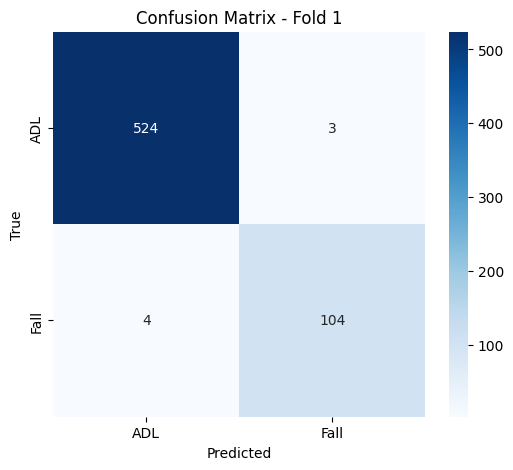

Training fold 2/5...
Before SMOTE: Counter({0: 2076, 1: 462})
After SMOTE: Counter({0: 2076, 1: 2076})
Epoch 1/100
260/260 [==============================] - 3s 9ms/step - loss: 0.1610 - accuracy: 0.9417
Epoch 2/100
260/260 [==============================] - 2s 9ms/step - loss: 0.1159 - accuracy: 0.9586
Epoch 3/100
260/260 [==============================] - 2s 8ms/step - loss: 0.1096 - accuracy: 0.9644
Epoch 4/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0907 - accuracy: 0.9694
Epoch 5/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0844 - accuracy: 0.9701
Epoch 6/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0857 - accuracy: 0.9704
Epoch 7/100
260/260 [==============================] - 2s 9ms/step - loss: 0.0685 - accuracy: 0.9786
Epoch 8/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0693 - accuracy: 0.9747
Epoch 9/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0814 - accur

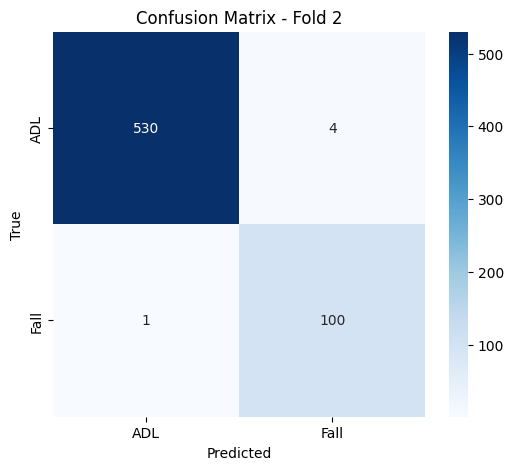

Training fold 3/5...
Before SMOTE: Counter({0: 2100, 1: 438})
After SMOTE: Counter({0: 2100, 1: 2100})
Epoch 1/100
263/263 [==============================] - 3s 9ms/step - loss: 0.1577 - accuracy: 0.9500
Epoch 2/100
263/263 [==============================] - 3s 10ms/step - loss: 0.1103 - accuracy: 0.9633
Epoch 3/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0930 - accuracy: 0.9681
Epoch 4/100
263/263 [==============================] - 3s 10ms/step - loss: 0.0820 - accuracy: 0.9738
Epoch 5/100
263/263 [==============================] - 3s 11ms/step - loss: 0.0735 - accuracy: 0.9781
Epoch 6/100
263/263 [==============================] - 3s 10ms/step - loss: 0.0635 - accuracy: 0.9783
Epoch 7/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0877 - accuracy: 0.9695
Epoch 8/100
263/263 [==============================] - 3s 10ms/step - loss: 0.0724 - accuracy: 0.9762
Epoch 9/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0617 - 

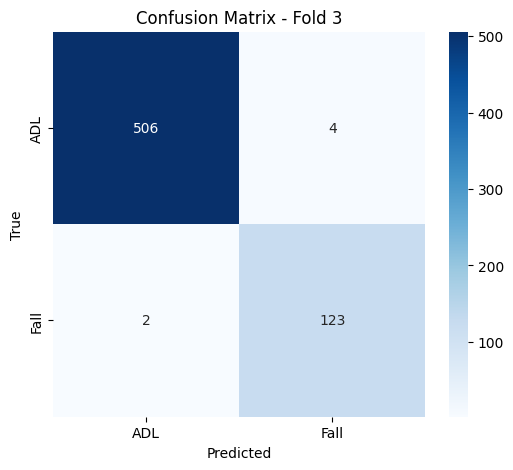

Training fold 4/5...
Before SMOTE: Counter({0: 2080, 1: 459})
After SMOTE: Counter({0: 2080, 1: 2080})
Epoch 1/100
260/260 [==============================] - 3s 9ms/step - loss: 0.1654 - accuracy: 0.9433
Epoch 2/100
260/260 [==============================] - 2s 8ms/step - loss: 0.1059 - accuracy: 0.9627
Epoch 3/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0981 - accuracy: 0.9695
Epoch 4/100
260/260 [==============================] - 2s 9ms/step - loss: 0.0837 - accuracy: 0.9712
Epoch 5/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0843 - accuracy: 0.9724
Epoch 6/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0731 - accuracy: 0.9767
Epoch 7/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0635 - accuracy: 0.9798
Epoch 8/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0682 - accuracy: 0.9793
Epoch 9/100
260/260 [==============================] - 2s 8ms/step - loss: 0.0540 - accur

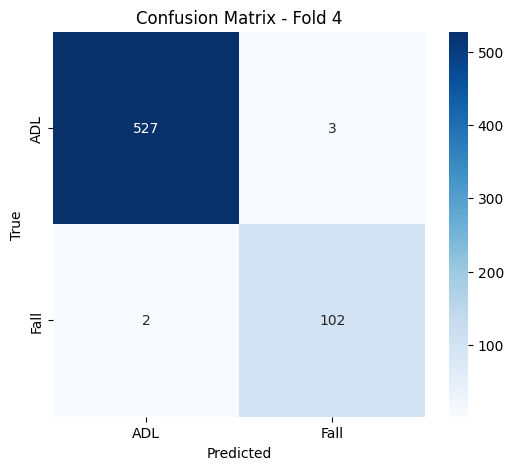

Training fold 5/5...
Before SMOTE: Counter({0: 2101, 1: 438})
After SMOTE: Counter({0: 2101, 1: 2101})
Epoch 1/100
263/263 [==============================] - 4s 10ms/step - loss: 0.1781 - accuracy: 0.9367
Epoch 2/100
263/263 [==============================] - 3s 10ms/step - loss: 0.1190 - accuracy: 0.9617
Epoch 3/100
263/263 [==============================] - 3s 10ms/step - loss: 0.1113 - accuracy: 0.9634
Epoch 4/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0979 - accuracy: 0.9657
Epoch 5/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0870 - accuracy: 0.9686
Epoch 6/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0868 - accuracy: 0.9731
Epoch 7/100
263/263 [==============================] - 3s 10ms/step - loss: 0.0774 - accuracy: 0.9736
Epoch 8/100
263/263 [==============================] - 3s 10ms/step - loss: 0.0761 - accuracy: 0.9755
Epoch 9/100
263/263 [==============================] - 2s 9ms/step - loss: 0.0617 - 

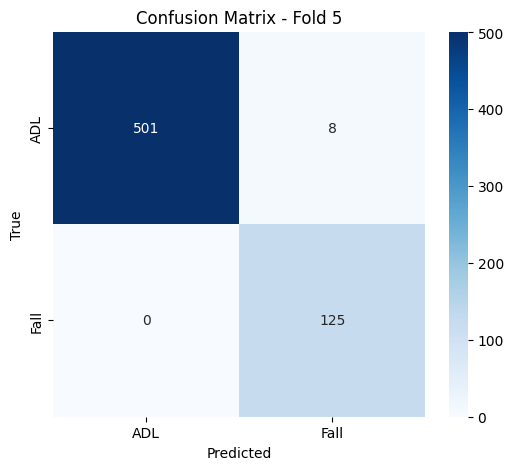

Average Accuracy: 0.9902 ± 0.0018
Average Specificity: 0.9915 ± 0.0037
Average Sensitivity: 0.9836 ± 0.0122


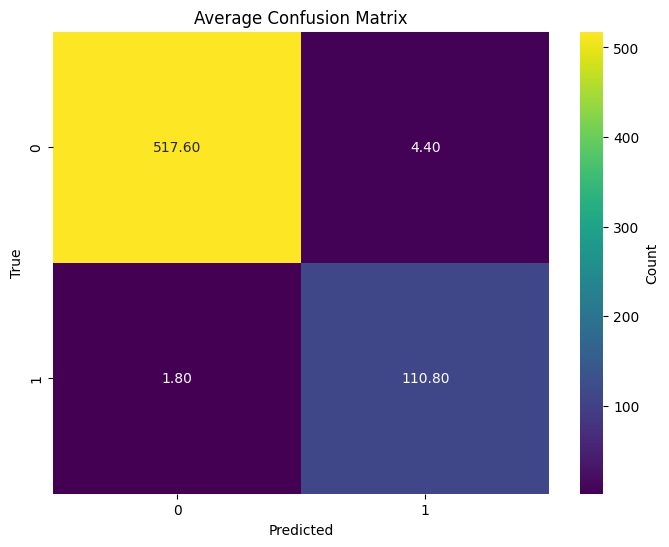

In [24]:
k_fold_cross_validation(X, y, k=5)

In [ ]:
Average Accuracy: 0.9902 ± 0.0018
Average Specificity: 0.9915 ± 0.0037
Average Sensitivity: 0.9836 ± 0.0122

In [ ]:
--------------------------------------------------------------- CATBOOST --------------------------------------------------------------------------

In [31]:
import numpy as np
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed():
    SEED = 0
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

# Hàm huấn luyện với K-fold cross-validation sử dụng CATBOOST
def k_fold_cross_validation_catboost(X, y, k=5):
    set_seed()
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrices = []
    smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Khởi tạo SMOTE
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f"Training fold {fold+1}/{k}...")
        
        # Chia dữ liệu cho fold hiện tại
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Áp dụng SMOTE trên tập huấn luyện
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        # Khởi tạo mô hình CatBoost
        model = CatBoostClassifier(
            n_estimators=500,        # Số lần lặp
            learning_rate=0.1,      # Tốc độ học
            depth=6,                # Độ sâu của cây
            loss_function='Logloss',# Hàm mất mát (Logloss cho bài toán phân loại nhị phân)
            random_seed=42,
            verbose=1,              # Tắt log chi tiết
        )

        from collections import Counter
        print(f"Before SMOTE: {Counter(y_train)}")
        print(f"After SMOTE: {Counter(y_train_balanced)}")
        
        # Huấn luyện mô hình
        model.fit(X_train_balanced, y_train_balanced)
        
        # Dự đoán trên bộ kiểm tra
        y_pred = model.predict(X_test)
        
        # Tính toán các chỉ số
        cm = confusion_matrix(y_test, y_pred)
        
        # Accuracy
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        # Sensitivity (Recall)
        sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        # Specificity (True Negative Rate)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        
        # Lưu lại các chỉ số cho từng fold
        accuracy_scores.append(accuracy)
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
        confusion_matrices.append(cm)  # Lưu ma trận vào danh sách
        
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        # Vẽ biểu đồ ma trận nhầm lẫn cho mỗi fold
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ADL', 'Fall'], yticklabels=['ADL', 'Fall'])
        plt.title(f"Confusion Matrix - Fold {fold+1}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    # Tính toán trung bình của các chỉ số trên tất cả các fold
    avg_accuracy = np.mean(accuracy_scores)
    avg_sensitivity = np.mean(sensitivity_scores)
    avg_specificity = np.mean(specificity_scores)
    
    # Tính độ lệch chuẩn cho các chỉ số
    std_accuracy = np.std(accuracy_scores)
    std_sensitivity = np.std(sensitivity_scores)
    std_specificity = np.std(specificity_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average Specificity: {avg_specificity:.4f} ± {std_specificity:.4f}")
    print(f"Average Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.4f}")

    # Tính toán ma trận nhầm lẫn trung bình từ các confusion matrices
    confusion_matrices_mean = np.mean(confusion_matrices, axis=0)
    
    # Vẽ ma trận nhầm lẫn trung bình
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices_mean, annot=True, fmt='.2f',xticklabels=['ADL', 'Fall'], yticklabels=['ADL', 'Fall'], cmap='viridis', cbar_kws={'label': 'Count'})
    plt.title('Average Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Training fold 1/5...
Before SMOTE: Counter({0: 2083, 1: 455})
After SMOTE: Counter({0: 2083, 1: 2083})
0:	learn: 0.5346944	total: 4.43ms	remaining: 2.21s
1:	learn: 0.4213062	total: 8.36ms	remaining: 2.08s
2:	learn: 0.3434036	total: 12ms	remaining: 1.99s
3:	learn: 0.2751285	total: 16ms	remaining: 1.98s
4:	learn: 0.2347742	total: 19.4ms	remaining: 1.92s
5:	learn: 0.1901646	total: 23.4ms	remaining: 1.93s
6:	learn: 0.1652165	total: 27.3ms	remaining: 1.92s
7:	learn: 0.1462573	total: 30.9ms	remaining: 1.9s
8:	learn: 0.1294332	total: 34.9ms	remaining: 1.9s
9:	learn: 0.1167384	total: 38.8ms	remaining: 1.9s
10:	learn: 0.1063798	total: 43.1ms	remaining: 1.91s
11:	learn: 0.0988063	total: 47.2ms	remaining: 1.92s
12:	learn: 0.0923574	total: 51.3ms	remaining: 1.92s
13:	learn: 0.0850394	total: 55.4ms	remaining: 1.92s
14:	learn: 0.0776647	total: 59.1ms	remaining: 1.91s
15:	learn: 0.0731713	total: 63.6ms	remaining: 1.93s
16:	learn: 0.0687755	total: 67.7ms	remaining: 1.92s
17:	learn: 0.0630581	total: 71

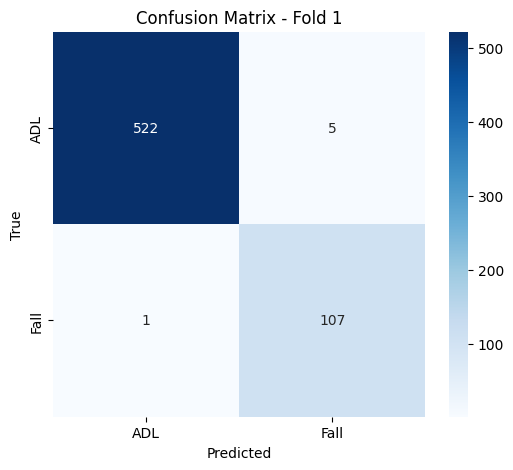

Training fold 2/5...
Before SMOTE: Counter({0: 2076, 1: 462})
After SMOTE: Counter({0: 2076, 1: 2076})
0:	learn: 0.5287758	total: 3.71ms	remaining: 1.85s
1:	learn: 0.4209669	total: 7.31ms	remaining: 1.82s
2:	learn: 0.3361712	total: 11.5ms	remaining: 1.91s
3:	learn: 0.2813722	total: 15.3ms	remaining: 1.89s
4:	learn: 0.2365545	total: 19.2ms	remaining: 1.9s
5:	learn: 0.2063270	total: 23.2ms	remaining: 1.91s
6:	learn: 0.1767750	total: 29.1ms	remaining: 2.05s
7:	learn: 0.1534483	total: 35ms	remaining: 2.15s
8:	learn: 0.1373818	total: 39.4ms	remaining: 2.15s
9:	learn: 0.1251902	total: 43ms	remaining: 2.1s
10:	learn: 0.1141999	total: 46.9ms	remaining: 2.09s
11:	learn: 0.1052038	total: 50.5ms	remaining: 2.05s
12:	learn: 0.0986515	total: 54.1ms	remaining: 2.02s
13:	learn: 0.0897339	total: 57.7ms	remaining: 2s
14:	learn: 0.0838587	total: 61.3ms	remaining: 1.98s
15:	learn: 0.0783224	total: 65.2ms	remaining: 1.97s
16:	learn: 0.0727818	total: 68.7ms	remaining: 1.95s
17:	learn: 0.0684179	total: 72.3

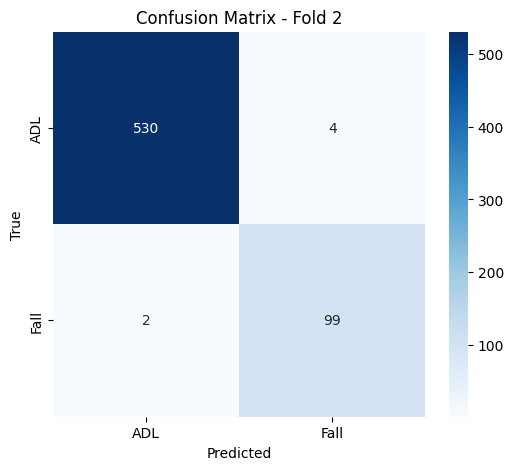

Training fold 3/5...
Before SMOTE: Counter({0: 2100, 1: 438})
After SMOTE: Counter({0: 2100, 1: 2100})
0:	learn: 0.5346586	total: 3.79ms	remaining: 1.89s
1:	learn: 0.4251237	total: 7.31ms	remaining: 1.82s
2:	learn: 0.3353015	total: 11ms	remaining: 1.82s
3:	learn: 0.2692951	total: 14.6ms	remaining: 1.81s
4:	learn: 0.2221885	total: 18.5ms	remaining: 1.83s
5:	learn: 0.1883778	total: 21.9ms	remaining: 1.8s
6:	learn: 0.1633483	total: 25.9ms	remaining: 1.83s
7:	learn: 0.1453720	total: 29.3ms	remaining: 1.8s
8:	learn: 0.1323737	total: 33.4ms	remaining: 1.82s
9:	learn: 0.1213592	total: 37.3ms	remaining: 1.83s
10:	learn: 0.1081025	total: 40.6ms	remaining: 1.81s
11:	learn: 0.1003307	total: 44.5ms	remaining: 1.81s
12:	learn: 0.0937005	total: 48.2ms	remaining: 1.81s
13:	learn: 0.0859912	total: 52.4ms	remaining: 1.82s
14:	learn: 0.0787015	total: 55.9ms	remaining: 1.81s
15:	learn: 0.0737057	total: 59.5ms	remaining: 1.8s
16:	learn: 0.0695191	total: 63.9ms	remaining: 1.82s
17:	learn: 0.0645453	total: 

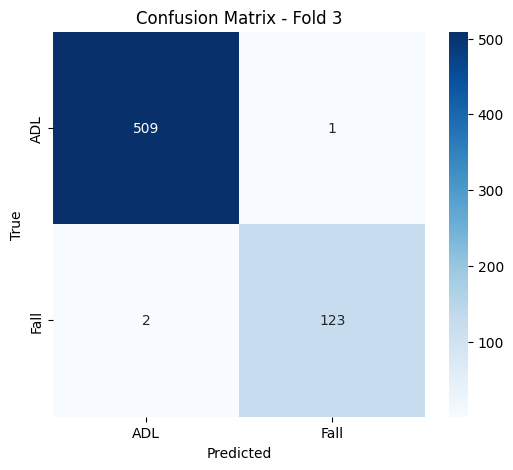

Training fold 4/5...
Before SMOTE: Counter({0: 2080, 1: 459})
After SMOTE: Counter({0: 2080, 1: 2080})
0:	learn: 0.5494080	total: 3.75ms	remaining: 1.87s
1:	learn: 0.4331012	total: 7.44ms	remaining: 1.85s
2:	learn: 0.3421681	total: 10.6ms	remaining: 1.75s
3:	learn: 0.2803867	total: 14ms	remaining: 1.73s
4:	learn: 0.2278106	total: 17.3ms	remaining: 1.71s
5:	learn: 0.1997277	total: 20.9ms	remaining: 1.72s
6:	learn: 0.1728431	total: 24.6ms	remaining: 1.73s
7:	learn: 0.1507048	total: 28.6ms	remaining: 1.76s
8:	learn: 0.1376898	total: 31.9ms	remaining: 1.74s
9:	learn: 0.1246222	total: 35.9ms	remaining: 1.76s
10:	learn: 0.1151546	total: 39.4ms	remaining: 1.75s
11:	learn: 0.1049326	total: 43ms	remaining: 1.75s
12:	learn: 0.0957968	total: 46.7ms	remaining: 1.75s
13:	learn: 0.0870546	total: 50.5ms	remaining: 1.75s
14:	learn: 0.0814334	total: 54.8ms	remaining: 1.77s
15:	learn: 0.0752216	total: 58.6ms	remaining: 1.77s
16:	learn: 0.0695600	total: 63.1ms	remaining: 1.79s
17:	learn: 0.0651012	total:

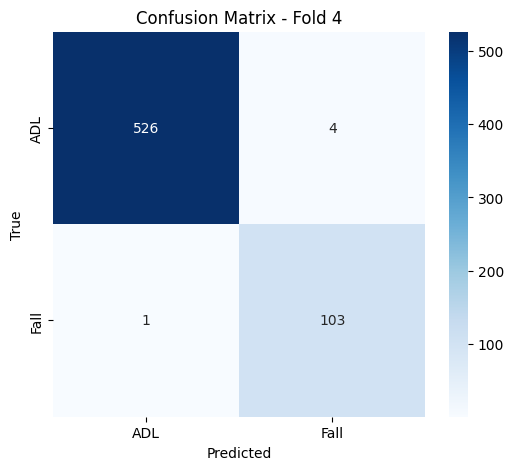

Training fold 5/5...
Before SMOTE: Counter({0: 2101, 1: 438})
After SMOTE: Counter({0: 2101, 1: 2101})
0:	learn: 0.5412172	total: 3.4ms	remaining: 1.7s
1:	learn: 0.4281098	total: 6.59ms	remaining: 1.64s
2:	learn: 0.3372869	total: 10.3ms	remaining: 1.7s
3:	learn: 0.2810002	total: 14.2ms	remaining: 1.76s
4:	learn: 0.2372240	total: 18ms	remaining: 1.78s
5:	learn: 0.2052681	total: 21.9ms	remaining: 1.8s
6:	learn: 0.1819200	total: 25.4ms	remaining: 1.79s
7:	learn: 0.1606114	total: 28.9ms	remaining: 1.77s
8:	learn: 0.1458223	total: 32.9ms	remaining: 1.79s
9:	learn: 0.1324563	total: 36.4ms	remaining: 1.78s
10:	learn: 0.1238514	total: 39.8ms	remaining: 1.77s
11:	learn: 0.1116127	total: 43.4ms	remaining: 1.76s
12:	learn: 0.1035397	total: 47.3ms	remaining: 1.77s
13:	learn: 0.0980592	total: 50.7ms	remaining: 1.76s
14:	learn: 0.0920953	total: 54.7ms	remaining: 1.77s
15:	learn: 0.0857100	total: 58.6ms	remaining: 1.77s
16:	learn: 0.0811054	total: 62.5ms	remaining: 1.77s
17:	learn: 0.0753539	total: 6

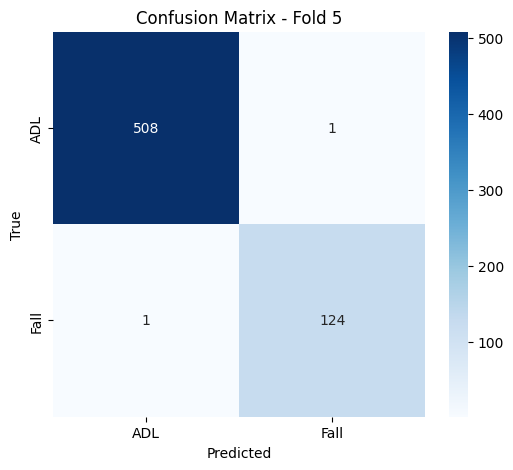

Average Accuracy: 0.9931 ± 0.0026
Average Specificity: 0.9943 ± 0.0031
Average Sensitivity: 0.9875 ± 0.0046


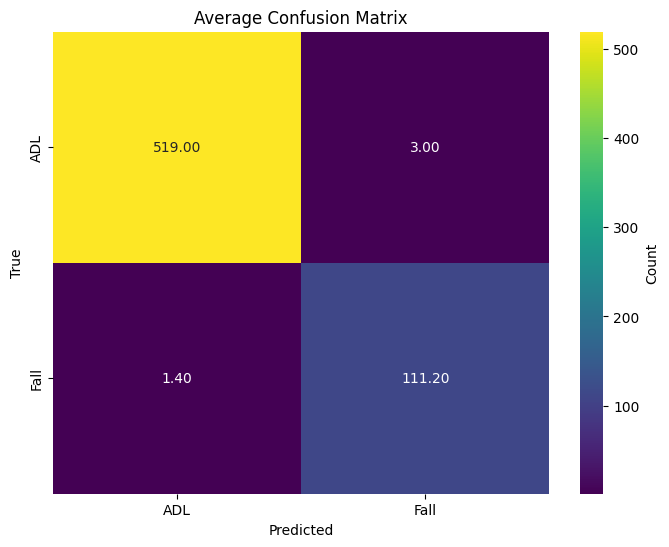

In [32]:
k_fold_cross_validation_catboost(X, y, k=5)

In [ ]:
Average Accuracy: 0.9931 ± 0.0026
Average Specificity: 0.9943 ± 0.0031
Average Sensitivity: 0.9875 ± 0.0046

In [141]:
import numpy as np
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed():
    SEED = 0
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

# Hàm huấn luyện với K-fold cross-validation sử dụng KNN
def k_fold_cross_validation_knn(X, y, k=5,new_threshold=0.5):
    set_seed()
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrices = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
        print(f"Training fold {fold}/{k}...")
        
        # Chia dữ liệu cho fold hiện tại
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Khởi tạo mô hình KNN
        knn = KNeighborsClassifier(n_neighbors=3,metric='euclidean')

        
        # Huấn luyện mô hình
        knn.fit(X_train, y_train) # 10 cho lớp 'Fall'
        
         # Dự đoán trên bộ kiểm tra
        y_prob = knn.predict_proba(X_test)[:, 1]  # Lấy xác suất dự đoán của lớp 'Fall'
        
        # Thay đổi ngưỡng
        y_pred_adjusted = (y_prob >= new_threshold).astype(int)
        
        # Tính toán các chỉ số
        cm = confusion_matrix(y_test, y_pred_adjusted)
        
        # Accuracy
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        # Sensitivity (Recall)
        sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        # Specificity (True Negative Rate)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        
        # Lưu lại các chỉ số cho từng fold
        accuracy_scores.append(accuracy)
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
        confusion_matrices.append(cm)
        
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        # Vẽ biểu đồ ma trận nhầm lẫn cho mỗi fold
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ADL', 'Fall'], yticklabels=['ADL', 'Fall'])
        plt.title(f"Confusion Matrix - Fold {fold}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
    # Tính toán trung bình của các chỉ số trên tất cả các fold
    avg_accuracy = np.mean(accuracy_scores)
    avg_sensitivity = np.mean(sensitivity_scores)
    avg_specificity = np.mean(specificity_scores)
    
    # Tính độ lệch chuẩn cho các chỉ số
    std_accuracy = np.std(accuracy_scores)
    std_sensitivity = np.std(sensitivity_scores)
    std_specificity = np.std(specificity_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Average Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.4f}")
    print(f"Average Specificity: {avg_specificity:.4f} ± {std_specificity:.4f}")
    
    # Tính toán ma trận nhầm lẫn trung bình từ các confusion matrices
    confusion_matrices_mean = np.mean(confusion_matrices, axis=0)
    
    # Vẽ ma trận nhầm lẫn trung bình
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices_mean, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Count'})
    plt.title('Average Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Training fold 1/5...
Fold 2 - Accuracy: 0.9827, Sensitivity: 0.9907, Specificity: 0.9810


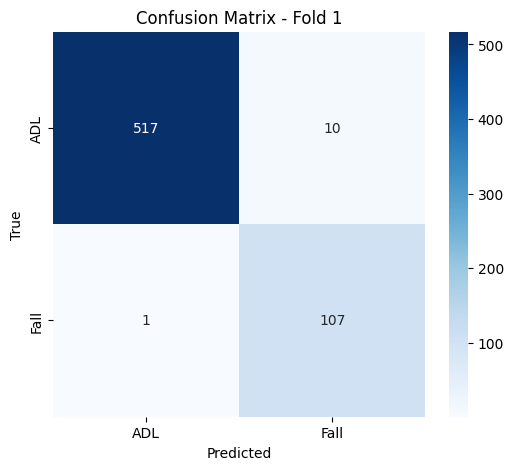

Training fold 2/5...
Fold 3 - Accuracy: 0.9811, Sensitivity: 0.9802, Specificity: 0.9813


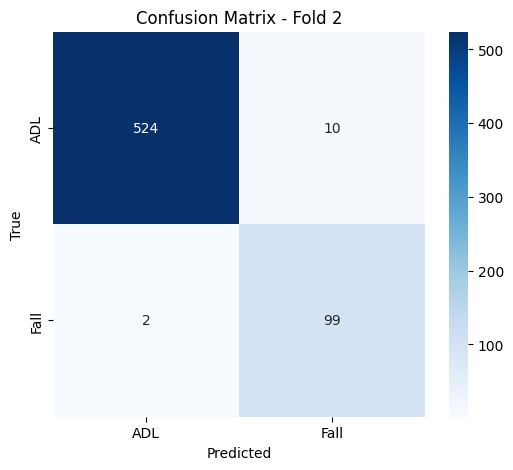

Training fold 3/5...
Fold 4 - Accuracy: 0.9843, Sensitivity: 1.0000, Specificity: 0.9804


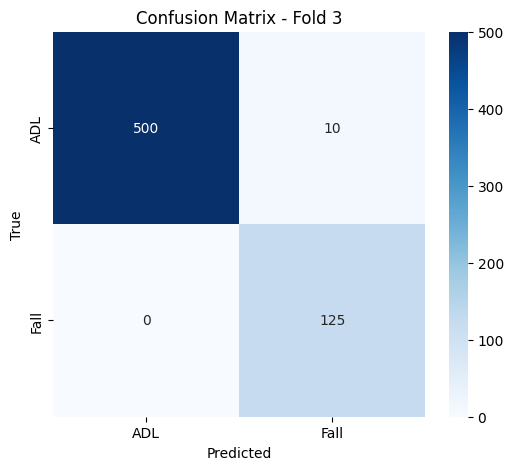

Training fold 4/5...
Fold 5 - Accuracy: 0.9685, Sensitivity: 0.9712, Specificity: 0.9679


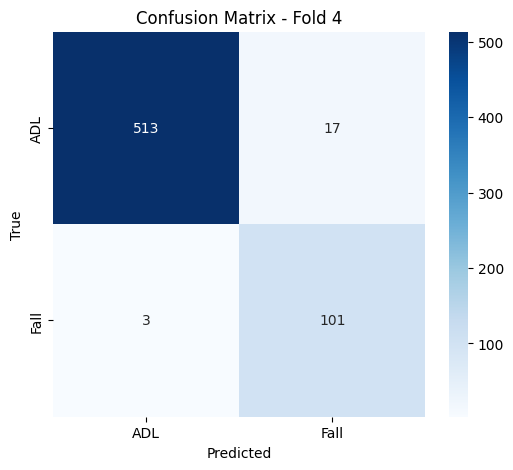

Training fold 5/5...
Fold 6 - Accuracy: 0.9874, Sensitivity: 0.9920, Specificity: 0.9862


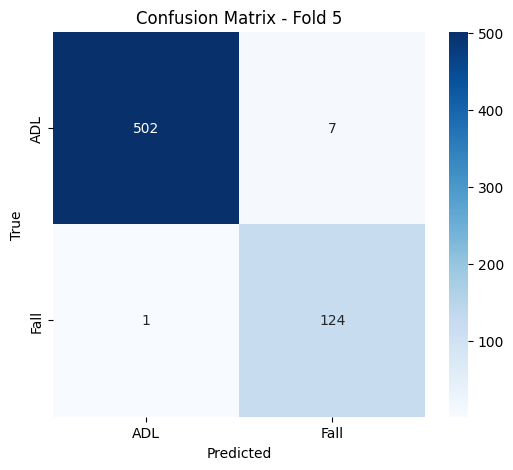

Average Accuracy: 0.9808 ± 0.0065
Average Sensitivity: 0.9868 ± 0.0101
Average Specificity: 0.9794 ± 0.0061


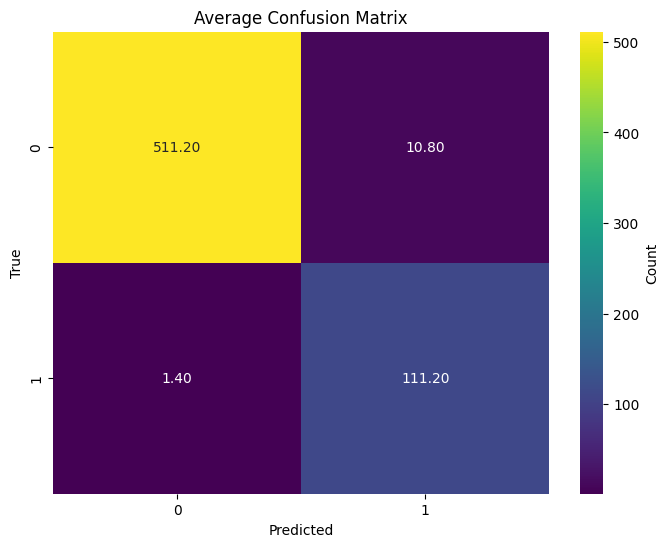

In [146]:
k_fold_cross_validation_knn(X, y,new_threshold=0.33)

In [133]:
Accuracy: 0.9864 ± 0.0032
Sensitivity: 0.9571 ± 0.0113
Specificity: 0.9928 ± 0.0036

SyntaxError: invalid character in identifier (3441372981.py, line 1)

In [ ]:
Accuracy: 98.03% ± 0.46
Specificity: 97.84% ± 0.83
Sensitivity: 98.25% ± 0.36


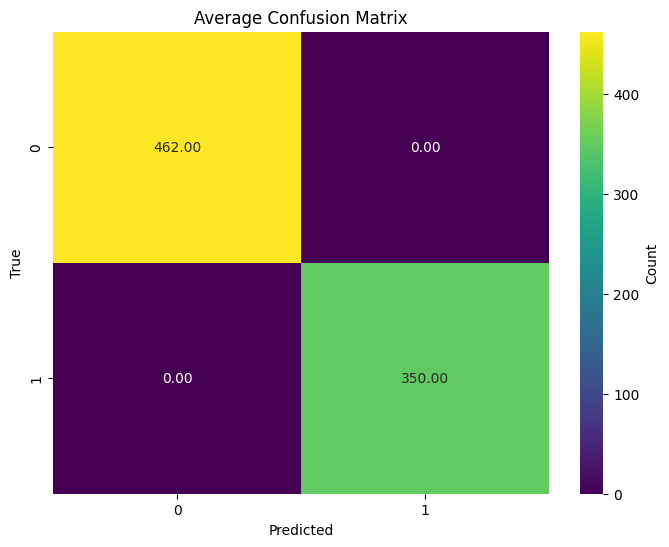

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Values given
true_negatives = 462
false_positives = 0
false_negatives = 0
true_positives = 350

# Create confusion matrix
confusion_matrix_mean = np.array([[true_negatives, false_positives],
                                  [false_negatives, true_positives]])

# Plot average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_mean, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Count'})
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
